In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import shap
import os
import sys

from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [19]:
def plotR2(modelname):
    '''
    Script to visualize the performance of a given ML model.
    Requires outputs of model training in step3_train.py.
    Generates plots of actual permeability against predicted permeability for 6 gases.
    
    Arguments:
        modelname: name of the folder containing the trained model.
        i.e. 'DNN_BLR_fing'   
    '''
    #reset the working directory
    os.chdir(sys.path[0])
    
    #load in the data from the model training
    os.chdir(os.getcwd() + '/models/' + modelname)
    Y_train=pd.read_csv('Y_train.csv', header=None)
    Y_train = Y_train.to_numpy()
    Y_pred_train=pd.read_csv('Y_pred_train.csv', header=None)
    Y_pred_train = Y_pred_train.to_numpy()
    Y_test=pd.read_csv('Y_test.csv', header=None)
    Y_test = Y_test.to_numpy()
    Y_pred_test=pd.read_csv('Y_pred_test.csv', header=None)
    Y_pred_test = Y_pred_test.to_numpy()

    #plot the performance of the model for six gases
    Columns = ['He','H2','O2','N2','CO2','CH4']

    fig = plt.figure(figsize=(12,8))
    for i in range(6):
        ax=plt.subplot(2, 3, i + 1)
        index = i #adjust so that we look at the last 4 gases
        plt.plot(Y_train[:,index], Y_pred_train[:,index], '.', color='tab:purple')#, alpha=0.8, label="Train R^2: {}".format(r2_score(y_train, Y_pred_train)))
        plt.plot(Y_test[:,index], Y_pred_test[:,index], 'g.')#, alpha=0.8, label="Test R^2: {}".format(r2_score(y_test, Y_pred_test)))
        plt.legend(['Train', 'Test'], loc = 'best')
        plt.xlabel(Columns[i]) 
        plt.ylabel("Predicted value")
        x0, x1 = min(Y_train[:,index]), max(Y_train[:,index])
        length = x1 - x0
        x_start, x_end = x0-0.1*length, x1+0.1*length
        plt.xlim([x_start, x_end])
        plt.ylim([x_start, x_end])
        
        # the unit line
        plt.plot(np.arange(x_start, x_end, 0.01*length),
        np.arange(x_start, x_end, 0.01*length), '-', color='tab:gray')
        plt.text(x_end - 0.7*length, x_start + 0.15*length, "$Train R^2={:.2f}$".format(r2_score(Y_train[:,index], Y_pred_train[:,index])))
        plt.text(x_end - 0.7*length, x_start + 0.05*length, "$Test R^2={:.2f}$".format(r2_score(Y_test[:,index], Y_pred_test[:,index])))
    
    plt.show()

def plotSHAP(modelname):
    '''
    Visualize the results of SHAP for a given ML model.
    Requires SHAP values to be saved from step3.5_SHAP.py.
    Generates (a) a SHAP summary plot for prediction of each permeability
    and (b) a bar graph showing the top 12 most important chemical features
    overall with respective impacts on 6 gas permeabilities.
    Arguments:
        modelname: name of the folder containing the trained model.
        i.e. 'DNN_BLR_fing'
    '''
    #reset the working directory
    os.chdir(sys.path[0])

    modeltype = modelname.split('_')[0]
    imputation = modelname.split('_')[1]
    features = modelname.split('_')[2]
    maindirectory = os.getcwd() + '/models/' + modelname
    
    X_df = pd.read_csv(os.getcwd() + '/datasets/datasetAX_' + features + '.csv')

    X = np.array(X_df)
    Xscaler = StandardScaler()
    X= Xscaler.fit_transform(X)

    os.chdir(maindirectory)
    shap_values = avg_shap_values = np.zeros((6, X.shape[0], X.shape[1]))
    for i in range(6):
        shap_values[i, :, :] = pd.read_csv('shap_' + str(i) + '.csv', header=None)

    for i in range(6):
        fig = plt.figure()
        shap.summary_plot(shap_values[i], X, show=False)
    plt.show()

    wts = np.zeros((X_df.shape[1],6))
    for i in range(6):
        wts[:,i] = np.mean(np.abs(shap_values[i]),0)
    wts = pd.DataFrame(wts)
    wts['sum'] = np.sum(wts, axis=1)
    wts['id'] = X_df.columns
    ordered_wts = wts.sort_values('sum', ascending=False)
    top_ordered_wts = ordered_wts.iloc[:12,:]
    top_ordered_wts = top_ordered_wts.rename(top_ordered_wts['id'])
    fig = plt.figure(figsize=(20, 5))
    top_ordered_wts.iloc[:,:6].plot(kind='bar', colormap='Set2')
    plt.legend(['He','H2','O2','N2','CO2','CH4'])
    plt.ylabel('Avg Magnitude of SHAP Value')
    plt.show()

def plotRobeson(filelist):
    '''
    Visualize permeability data in the O2/N2, CO2/CH4, CO2/N2, and H2/CO2 Robeson spaces.
    Data must be a csv file with 6 columns in the order of ['He','H2','O2','N2','CO2','CH4'] permeabilities.
    Update the filelist list with paths to each of the .csv files that are desired.
    Works with the .csv outputs of screen.py and train.py.

    Arguments:
        list containing the paths to each of the outputed prediction files
        i.e. ['models/DNN_BLR_fing/Y_pred_datasetCX_fing_0.csv', ..]
    '''
    #reset the working directory
    os.chdir(sys.path[0])
    
    #plot permeability values on a Robeson plot
    sns.set_palette("bright")
    fig = plt.figure(figsize=(12,8))

    for i, dataset in enumerate(filelist):
        #read in the permeability data for each dataset
        Y_pred = pd.read_csv(dataset, header=None)
        Y_pred = np.array(Y_pred)

        #O2/N2 separations
        plt.subplot(2,2,1)
        permeability = Y_pred[:,-4]
        selectivity = Y_pred[:,-4] - Y_pred[:,-3]
        plt.plot(permeability, selectivity, '.', alpha = 0.2)

        #CO2/CH4 separations
        plt.subplot(2,2,2)
        permeability = Y_pred[:,-2]
        selectivity = Y_pred[:,-2] - Y_pred[:,-1]
        plt.plot(permeability, selectivity, '.', alpha=0.2)

        #CO2/N2 separations
        plt.subplot(2,2,3)
        permeability = Y_pred[:,-2]
        selectivity = Y_pred[:,-2] - Y_pred[:,-3]
        plt.plot(permeability, selectivity, '.', alpha=0.2)

        #H2/CO2 separations
        plt.subplot(2,2,4)
        permeability = Y_pred[:,-5]
        selectivity = Y_pred[:,-5] - Y_pred[:,-2]
        plt.plot(permeability, selectivity, '.', alpha=0.2)
        
    #format the plot and add Robeson upper bounds
    plt.subplot(2,2,1)
    xmin = -4
    xmax = 7
    plt.xlim([xmin, xmax])
    plt.ylim([-1, 2])
    plt.plot([xmin, xmax], [np.log10(9.2008)-0.1724*xmin, np.log10(9.2008)-0.1724*xmax], '-k') #1991 upper bound
    plt.plot([xmin, xmax], [np.log10(12.148)-0.1765*xmin, np.log10(12.148)-0.1765*xmax], '--k') #2008 upper bound
    plt.plot([xmin, xmax], [np.log10(18.50)-0.1754*xmin, np.log10(18.50)-0.1754*xmax], ':k') #2015 upper bound
    plt.title("O2/N2 Separations")

    plt.subplot(2,2,2)
    xmin = -2
    xmax =7
    plt.xlim([xmin, xmax])
    plt.ylim([-2, 4])
    plt.plot([xmin, xmax], [np.log10(197.81)-0.3807*xmin, np.log10(197.81)-0.3807*xmax], '-k') #1991 upper bound
    plt.plot([xmin, xmax], [np.log10(357.33)-0.3794*xmin, np.log10(357.33)-0.3794*xmax], '--k') #2008 upper bound
    plt.plot([xmin, xmax], [np.log10(1155.60)-0.4165*xmin, np.log10(1155.60)-0.4165*xmax], ':k') #2019 upper bound
    plt.title('CO2/CH4 Separations')

    plt.subplot(2,2,3)
    xmin = -2
    xmax =7
    plt.xlim([xmin, xmax])
    plt.ylim([-1, 3])
    plt.plot([xmin, xmax], -1/2.888*np.array([-np.log10(30967000)+xmin, -np.log10(30967000)+xmax]), '--k') #2008 upper bound
    plt.plot([xmin, xmax], -1/3.409*np.array([-np.log10(755.58e6)+xmin, -np.log10(755.58e6)+xmax]), ':k') #2019 upper bound
    plt.title('CO2/N2 Separations')

    plt.subplot(2,2,4)
    xmin = -2
    xmax =7
    plt.xlim([xmin, xmax])
    plt.ylim([-1.5, 2])
    plt.plot([xmin, xmax], -1/1.9363*np.array([-np.log10(1200)+xmin, -np.log10(1200)+xmax]), '-k') #1991 upper bound
    plt.plot([xmin, xmax], -1/2.302*np.array([-np.log10(4515)+xmin, -np.log10(4515)+xmax]), '--k') #2008 upper bound
    plt.title('H2/CO2 Separations')

    plt.show()

models/RF_BLR_fing


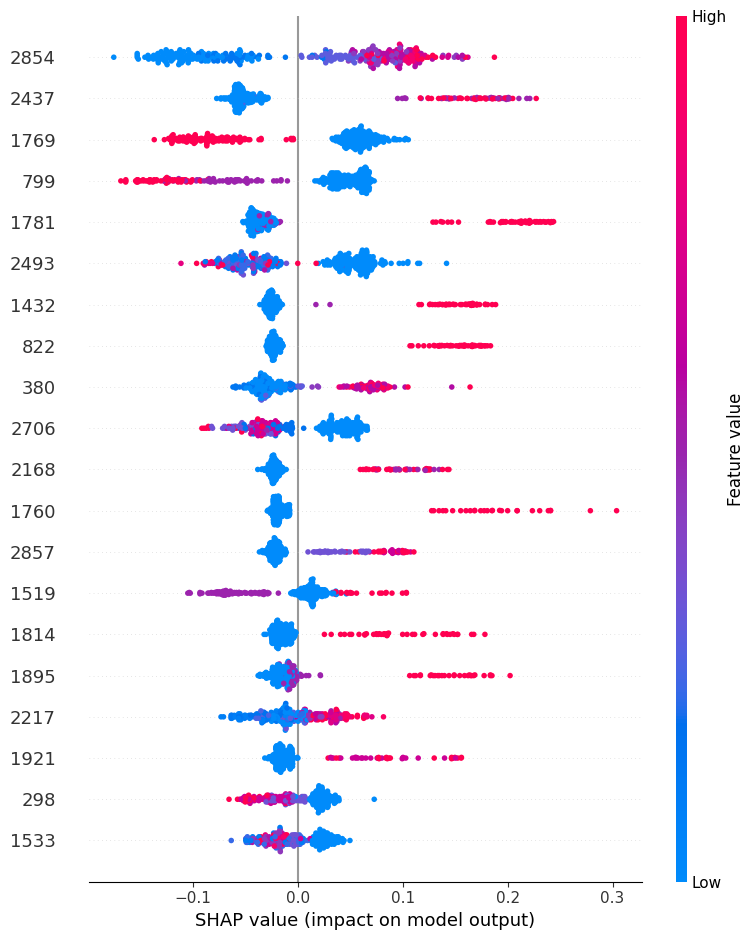

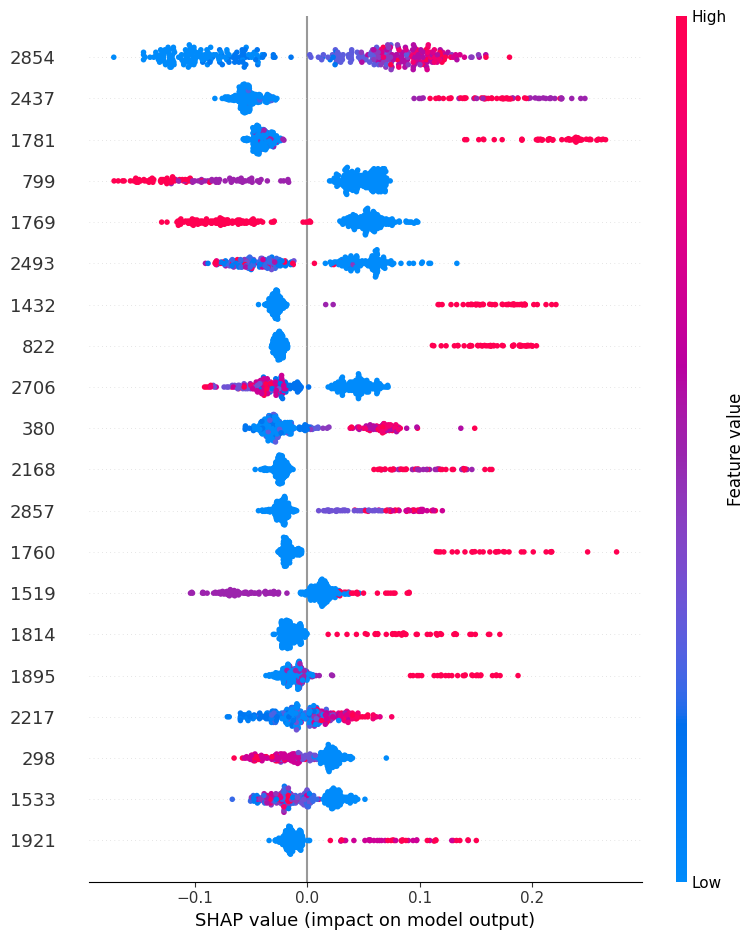

gas_names: ['CO2', 'N2']
top.columns: Index(['CO2', 'N2', 'sum'], dtype='object')
CO2    float64
N2     float64
dtype: object
             CO2        N2
bit_id                    
2854    0.086818  0.085122
2437    0.072941  0.073546
1781    0.064351  0.069242
1769    0.068895  0.062937
799     0.064471  0.065076


<Figure size 1800x500 with 0 Axes>

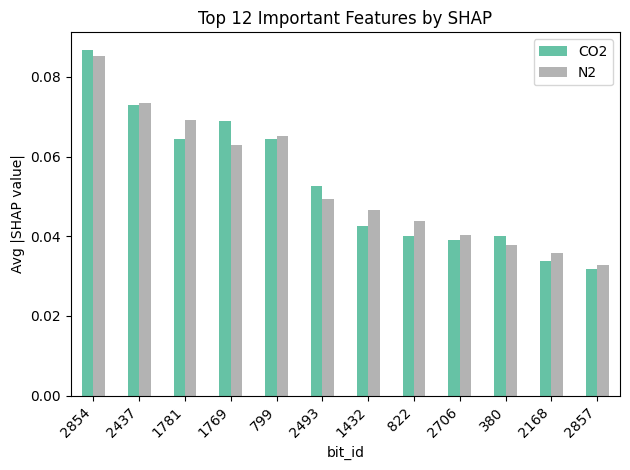

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import glob
from sklearn.preprocessing import StandardScaler

# === 修改为你的模型名称 ===
modelname = 'RF_BLR_fing'

# === 解析模型信息（不要用 sys.path）===
modeltype = modelname.split('_')[0]
features = modelname.split('_')[2]
maindirectory = os.path.join('models', modelname)  # 相对路径

# === 加载输入特征 ===
X_df = pd.read_csv(os.path.join('datasets', 'datasetAX_' + features + '.csv'))
X = np.array(X_df)
feature_names = list(X_df.columns)

# === 切换到模型目录加载 SHAP 文件 ===
shap_files = sorted(glob.glob(os.path.join(maindirectory, "shap_*.csv")))
print(maindirectory)
gas_names = [f.split('_')[-1].split('.')[0] for f in shap_files]
n_outputs = len(gas_names)

shap_values = np.zeros((n_outputs, X.shape[0], X.shape[1]))
for i in range(n_outputs):
    shap_values[i] = pd.read_csv(shap_files[i], header=None).values

# === summary plot ===
for i in range(n_outputs):
    plt.figure()
    shap.summary_plot(shap_values[i], X, feature_names=feature_names, show=False)
plt.show()

# === bar plot ===
wts = np.zeros((X.shape[1], n_outputs))
for i in range(n_outputs):
    wts[:, i] = np.mean(np.abs(shap_values[i]), axis=0)

wts_df = pd.DataFrame(wts, columns=gas_names)
wts_df['sum'] = wts_df.sum(axis=1)
wts_df['bit_id'] = feature_names
top = wts_df.sort_values('sum', ascending=False).head(12)
top = top.set_index('bit_id')
print("gas_names:", gas_names)
print("top.columns:", top.columns)
print(top[gas_names].dtypes)
print(top[gas_names].head())

plt.figure(figsize=(18, 5))
top[gas_names].plot(kind='bar', colormap='Set2')
plt.ylabel('Avg |SHAP value|')
plt.xticks(rotation=45, ha='right')
plt.title('Top 12 Important Features by SHAP')
plt.tight_layout()
plt.show()


In [15]:
import os
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import rdMolDraw2D
from collections import defaultdict

# === 参数 ===
smiles_file = 'high_score_molecules.csv'
top_bits_file = 'Top_features_CO2.csv'
corr_df_file = 'Corr_df.csv'  # 必须保存你生成 MFF 时用的 Corr_df！
output_dir = 'bit_fragments_output_top3'
radius = 3
top_k = 3

# === 准备输出目录 ===
os.makedirs(output_dir, exist_ok=True)

# === 读取数据 ===
smiles_df = pd.read_csv(smiles_file)
top_bits_df = pd.read_csv(top_bits_file)
corr_df = pd.read_csv(corr_df_file, index_col=0)  # index 是列编号，值是 bit_id
bit_indexes = top_bits_df['bit_id'].astype(int).tolist()  # 实际上是列号
bit_ids = corr_df.loc[bit_indexes, '0'].astype(int).tolist()  # 查找哈希值

# === 函数：绘图 ===
def save_mol_image(mol, filename, legend=''):
    d2d = rdMolDraw2D.MolDraw2DCairo(300, 300)
    d2d.drawOptions().addAtomIndices = False
    rdMolDraw2D.PrepareAndDrawMolecule(d2d, mol, legend=legend)
    d2d.FinishDrawing()
    with open(filename, 'wb') as f:
        f.write(d2d.GetDrawingText())

# === 提取子结构 ===
bit_to_struct_freq = defaultdict(lambda: defaultdict(int))
matched_bit_ids = set()

for smi in smiles_df['Smiles']:
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        continue
    info = {}
    AllChem.GetMorganFingerprint(mol, radius=radius, bitInfo=info)  # 保持一致
    print(f"example bitInfo keys from a molecule: {list(info.keys())[:10]}")
    print(f"your bit_ids: {bit_ids}")
    for bit_id in bit_ids:
        if bit_id not in info:
            continue
        matched_bit_ids.add(bit_id)
        for atom_idx, rad in info[bit_id]:
            env = Chem.FindAtomEnvironmentOfRadiusN(mol, rad, atom_idx)
            if not env:
                continue
            try:
                submol = Chem.PathToSubmol(mol, env)
                submol_smiles = Chem.MolToSmiles(submol)
                bit_to_struct_freq[bit_id][submol_smiles] += 1
            except:
                continue

# === 输出 CSV 和结构图 ===
out_data = []

for bit_id, struct_dict in bit_to_struct_freq.items():
    sorted_structs = sorted(struct_dict.items(), key=lambda x: x[1], reverse=True)[:top_k]
    for i, (sub_smiles, freq) in enumerate(sorted_structs, start=1):
        out_data.append({'bit_id': bit_id, 'substructure_smiles': sub_smiles, 'count': freq})
        try:
            mol = Chem.MolFromSmiles(sub_smiles)
            img_file = os.path.join(output_dir, f'bit_{bit_id}_top{i}.png')
            save_mol_image(mol, img_file, legend=f'bit {bit_id}, freq {freq}')
        except:
            continue

# 保存表格
out_df = pd.DataFrame(out_data)
out_df.to_csv(os.path.join(output_dir, 'bit_top_substructures.csv'), index=False)

print(f"✅ 完成：共成功还原 bit_id 数：{len(matched_bit_ids)} / {len(bit_ids)}")
print(f"📁 输出文件保存于：{output_dir}")


example bitInfo keys from a molecule: [68619296, 107290117, 392737424, 413188872, 453586909, 517734866, 1236995907, 1273561205, 1696036751, 1836178650]
your bit_ids: [392737424, 2246728737, 3388977530, 2968968094, 1302073591, 2245384272, 864942730, 2238101436, 1510328189, 1298690312, 864674487, 951226070, 647744938, 533204632]
example bitInfo keys from a molecule: [184934517, 243561060, 390375879, 392737424, 453586909, 481198828, 492392761, 517734866, 745217892, 767214971]
your bit_ids: [392737424, 2246728737, 3388977530, 2968968094, 1302073591, 2245384272, 864942730, 2238101436, 1510328189, 1298690312, 864674487, 951226070, 647744938, 533204632]
example bitInfo keys from a molecule: [108593968, 281134873, 390375879, 392737424, 453586909, 481198828, 492392761, 517734866, 540796485, 548273233]
your bit_ids: [392737424, 2246728737, 3388977530, 2968968094, 1302073591, 2245384272, 864942730, 2238101436, 1510328189, 1298690312, 864674487, 951226070, 647744938, 533204632]
example bitInfo key

In [16]:
import os
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import rdMolDraw2D

# === 参数设置 ===
smiles_file = 'high_score_molecules.csv'
top_bits_file = 'Top_features_CO2.csv'
output_dir = 'bit_fragments_output_top3'
radius = 3
nBits = 3209  # 确保覆盖所有可能 bit
top_k = 3  # 保留每个 bit 最常见的前 top_k 个结构

# === 创建输出文件夹 ===
os.makedirs(output_dir, exist_ok=True)

# === 读取数据 ===
smiles_df = pd.read_csv(smiles_file)
top_bits_df = pd.read_csv(top_bits_file)
top_bit_ids = top_bits_df['bit_id'].astype(int).tolist()

# === 函数：保存结构图像 ===
def save_mol_image(mol, filename, legend=''):
    d2d = rdMolDraw2D.MolDraw2DCairo(300, 300)
    d2d.drawOptions().addAtomIndices = False
    rdMolDraw2D.PrepareAndDrawMolecule(d2d, mol, legend=legend)
    d2d.FinishDrawing()
    with open(filename, 'wb') as f:
        f.write(d2d.GetDrawingText())

# === bit_id → 结构频率统计 dict ===
bit_to_struct_freq = {}
matched_bit_ids = set()

for smi in smiles_df['Smiles']:
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        continue
    info = {}
    _ = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits, bitInfo=info)

    for bit_id in top_bit_ids:
        if bit_id not in info:
            continue
        matched_bit_ids.add(bit_id)
        for atom_idx, rad in info[bit_id]:
            env = Chem.FindAtomEnvironmentOfRadiusN(mol, rad, atom_idx)
            if not env:
                continue
            try:
                submol = Chem.PathToSubmol(mol, env)
                submol_smiles = Chem.MolToSmiles(submol)
                if bit_id not in bit_to_struct_freq:
                    bit_to_struct_freq[bit_id] = {}
                if submol_smiles not in bit_to_struct_freq[bit_id]:
                    bit_to_struct_freq[bit_id][submol_smiles] = 0
                bit_to_struct_freq[bit_id][submol_smiles] += 1
            except:
                continue

# === 输出 CSV 和结构图 ===
out_data = []

for bit_id, struct_freq_dict in bit_to_struct_freq.items():
    # 排序，取出现频率最高的 top_k 个结构
    sorted_structs = sorted(struct_freq_dict.items(), key=lambda x: x[1], reverse=True)[:top_k]
    for i, (sub_smiles, freq) in enumerate(sorted_structs, start=1):
        out_data.append({'bit_id': bit_id, 'substructure_smiles': sub_smiles, 'count': freq})
        try:
            mol = Chem.MolFromSmiles(sub_smiles)
            img_file = os.path.join(output_dir, f'bit_{bit_id}_top{i}.png')
            save_mol_image(mol, img_file, legend=f'bit {bit_id}, freq {freq}')
        except:
            continue

# 保存汇总表格
out_df = pd.DataFrame(out_data)
out_df.to_csv(os.path.join(output_dir, 'bit_top_substructures.csv'), index=False)

print(f"✅ 完成：共成功还原 bit_id 数：{len(matched_bit_ids)} / {len(top_bit_ids)}")
print(f"📁 输出文件保存于：{output_dir}")

✅ 完成：共成功还原 bit_id 数：12 / 14
📁 输出文件保存于：bit_fragments_output_top3


In [5]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem

radius = 3
nBits = 4096  # 比 2048 更安全，避免 bit 截断
smiles_df = pd.read_csv("datasetA_grouped.csv")
top_bits_df = pd.read_csv("Top_features_CO2.csv")
top_bit_ids = set(top_bits_df['bit_id'].astype(int))

bit_match_counter = {bit: 0 for bit in top_bit_ids}

for smi in smiles_df['Smiles']:
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        continue
    info = {}
    _ = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits, bitInfo=info)
    for bit_id in top_bit_ids:
        if bit_id in info:
            bit_match_counter[bit_id] += 1

matched_bits = [bit for bit, count in bit_match_counter.items() if count > 0]

print(f"✅ 匹配成功的 bit 个数：{len(matched_bits)} / {len(top_bit_ids)}")
print(f"👉 匹配上的 bit_id 列表：{matched_bits}")


✅ 匹配成功的 bit 个数：61 / 114
👉 匹配上的 bit_id 列表：[516, 1539, 1032, 2569, 3093, 3106, 1572, 2095, 2103, 1597, 583, 589, 2647, 1116, 93, 1630, 620, 1660, 1160, 2728, 1196, 691, 2766, 2768, 724, 2273, 746, 237, 1781, 2814, 2818, 277, 790, 799, 2854, 2342, 2857, 1851, 1866, 866, 2411, 887, 380, 2429, 2432, 1921, 2437, 2439, 1442, 1446, 2984, 2480, 3002, 2493, 2508, 984, 2015, 1510, 500, 2552, 1533]
